# Lab 2 : Lossy image compression

### Question 1

Pour ce TP, on s'appuie donc sur l'image "bird_small.tiff", qui représente un oiseau très coloré : avoir plusieurs couleurs bien distinctes sur une image est idéal pour appliquer l'algorithme des k-means.

On charge l'image et on place la liste de ses pixels dans la variable "A", qui est un tableau numpy :

In [1]:
from PIL import Image
import numpy as np

im = Image.open('ex9Data/bird_small.tiff')
pix = im.load()
A = np.array([pix[x, y] for y in range(im.size[1]) for x in range(im.size[0])])

Cette fois, au lieu d'être représenté sous la forme d'un "0" ou d'un "1", les pixels sont représentés par un triplet d'entiers compris entre 0 et 255.

Voici la visualisation de cette image :

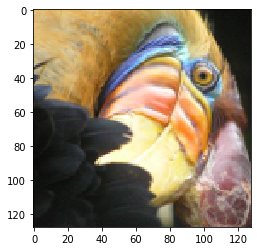

In [3]:
import matplotlib.pyplot as plt
plt.imshow(np.reshape(A, (128, 128, 3)))

### Question 2

On définit une fonction implémentant l'algorithme des k-means sur notre image.

Elle prend en paramètre la liste de pixels et k le nombre de clusters à obtenir, et après avoir appliqué l'algorithme des k-means sur cette liste, elle retourne une nouvelle liste de pixels telle que chaque pixel de l'image originale est remplacé par le cluster centroid (i.e. le pixel "moyen" d'un cluster) du cluster qui lui correspond :

In [4]:
from sklearn.cluster import KMeans

def k_means(A, k):
    k_means = KMeans(n_clusters=k).fit(A)
    values = k_means.cluster_centers_
    labels = k_means.labels_
    Y = values[labels,:]
    return np.array([[int(Y[i][j]) for j in range(3)] for i in range(16384)])

### Question 3

On applique cette fonction sur la liste de pixels de notre image, avec k=10, et on crée une nouvelle image avec la liste de pixels ainsi retournée, dont on obtient la visualisation (on appelle cette image "approximation" de l'image originale) :

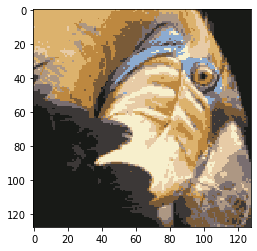

In [5]:
plt.imshow(np.reshape(k_means(A, 10), (128, 128, 3)))

### Question 4

On définit la fonction D(A, k), qui retourne l'erreur quadratique moyenne entre une image et son approximation, en fonction de k :

In [6]:
from sklearn.metrics import mean_squared_error

def D(A, k):
    return mean_squared_error(A, k_means(A, k))

On calcule D(A, k) pour l'approximation obtenue à la question 3 :

In [9]:
print(D(A, 10))

249.03173828125


On souhaite maintenant définir la fonction R(A, k), qui retourne le nombre de bits par pixel nécessaires pour encoder l'approximation d'une image par l'algorithme des k-means en suivant un codage RLE (le principe de ce codage est expliqué dans le TP 1).

Pour cela, définissons d'abord la fonction permettant d'encoder une suite de pixels (où chaque pixel est représenté par un triplet d'entiers) selon l'approche RLE :

In [7]:
def RLE(data): #le tableau en entrée doit être de deux dimensions !
    answer_list = []
    elem = data[0]
    count = 1
    for i in range(1, len(data)):
        if (data[i] == elem).all() :
            count += 1
        else :
            answer_list.append((elem, count))
            elem = data[i]
            count = 1
    answer_list.append((elem, count))
    return np.array(answer_list)

Observons le codage RLE de l'approximation obtenue à la question 3 :

In [15]:
print(RLE(k_means(A, 10)))

[[array([219, 178, 110]) 48]
 [array([193, 138,  66]) 12]
 [array([219, 178, 110]) 1]
 ...
 [array([129,  95,  55]) 1]
 [array([64, 59, 57]) 4]
 [array([25, 26, 24]) 1]]


On définit ensuite la fonction R(A, k).

En Python, un entier est codé sur 32 bits, et le codage RLE que l'on a mis au point retourne un tableau contenant 4 entiers par ligne (trois pour un pixel, un pour le nombre de fois d'affilée où ce pixel apparaît) : il faut donc multiplier la longueur du tableau obtenu par 4\*32 pour obtenir la longueur totale du codage des pixels de l'image (et diviser par le nombre de pixels pour obtenir le nombre de bits par pixel nécessaire à l'encodage de l'image).

In [8]:
def R(A, k):
    return (len(RLE(k_means(A, k)))*4*32)/len(A)

On calcule R(A, k) pour l'approximation obtenue à la question 3 :

In [10]:
print(R(A, 10))

29.8828125


### Question 5

Traçons l'évolution de D(A, k) en fonction de R(A, k), pour k allant de 2 à 20 :

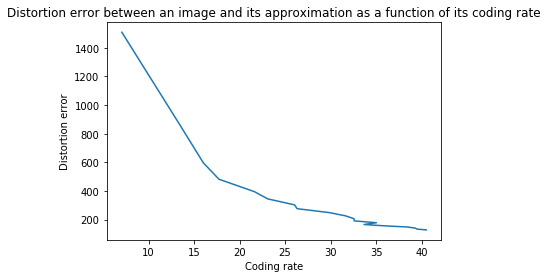

In [11]:
X, Y = [], []
for k in range(2, 21) :
    X.append(R(A, k))
    Y.append(D(A, k))
plt.title("Distortion error between an image and its approximation as a function of its coding rate")
plt.plot(X, Y)
plt.xlabel("Coding rate")
plt.ylabel("Distortion error")
plt.show()

On observe que cette courbe décroît.

En effet, plus l'approximation d'une image est imprécise, i.e. moins il y a de clusters pour établir cette approximation (k faible), plus l'erreur quadratique moyenne entre cette approximation et l'image originale sera élevée ; par ailleurs, un nombre réduit de clusters signifie un nombre réduit de pixels différents, et donc une longueur d'encodage plus faible grâce au codage RLE.

C'est pourquoi une valeur de D(A, k) élevée est associée à une valeur de R(A, k) faible, et inversement.

### Question 6

On cherche maintenant à obtenir un véritable codeur-décodeur permettant de sauvegarder et de retrouver une image comme la nôtre.

La partie "encodage" a été en partie établie au cours des questions précédentes : en effet, on a pu encoder une image sous la forme d'un tableau d'entiers relativement réduit. Pour achever cette partie, il faudrait que ce tableau ne contienne pas des entiers, mais leurs équivalents en caractères, comme cela se fait souvent en pratique.

Définissons donc une fonction prenant en paramètre une suite de pixels (codés sous forme de triplets d'entiers) et retournant son codage RLE alternatif (c'est-à-dire un tableau où chaque entier est remplacé par son caractère équivalent) :

In [12]:
def RLE_real_codec(data):
    rle = RLE(data)
    return np.array([(np.array([chr(rle[i][0][0]), chr(rle[i][0][1]), chr(rle[i][0][2])]), chr(rle[i][1])) for i in range(len(rle))])

Voyons ce que l'on obtient pour l'approximation définie à la question 3 :

In [16]:
print(RLE_real_codec(k_means(A, 10)))

[[array(['Ü', '²', 'm'], dtype='<U1') '0']
 [array(['¾', '\x89', 'A'], dtype='<U1') '\x01']
 [array(['Ü', '²', 'm'], dtype='<U1') '\x02']
 ...
 [array(['z', 'o', 'p'], dtype='<U1') '\x02']
 [array(['|', '\\', '8'], dtype='<U1') '\x02']
 [array(['=', '9', '7'], dtype='<U1') '\x04']]


Nous pouvons maintenant écrire les fonctions correspondant au décodage d'un tel tableau.

En premier lieu, il faudrait pouvoir retrouver le codage RLE original, c'est-à-dire un tableau contenant des entiers. Écrivons la fonction correspondante, qui prend en paramètre un tableau de caractères comme le précédent :

In [17]:
def RLE_code_from_real_codec(rle_rC):
    return np.array([(np.array([ord(rle_rC[i][0][0]), ord(rle_rC[i][0][1]), ord(rle_rC[i][0][2])]), ord(rle_rC[i][1])) for i in range(len(rle_rC))])

En partant de l'approximation déterminée à la question 3, vérifions que le codage RLE utilisant des entiers de cette approximation est bien le même lorsqu'on décode le codage RLE utilisant des caractères :

In [42]:
approx = k_means(A, 10)
rle = RLE(approx)
rle_test = RLE_code_from_real_codec(RLE_real_codec(approx))
answer = True
for i in range(len(rle)):
    answer = answer and (rle[i][0] == rle_test[i][0]).all() and rle[i][1] == rle_test[i][1]
print(answer)

True


Il faudrait maintenant pouvoir retrouver la taille du codage RLE original. Définissons donc la fonction prenant en paramètres un tableau correspondant à un encodage RLE utilisant des caractères, et donnant la taille de l'encodage RLE original équivalent :

In [24]:
def size_of_RLE_code_from_real_codec(rle_rC):
    return len(RLE_code_from_real_codec(rle_rC))

En partant de l'approximation déterminée à la question 3, vérifions que le codage RLE utilisant des entiers de cette approximation a bien la même taille que le décodage du codage RLE utilisant des caractères :

In [26]:
approx = k_means(A, 10)
print(len(RLE(approx)) == size_of_RLE_code_from_real_codec(RLE_real_codec(approx)))

True


On souhaite maintenant pouvoir retourner l'ensemble des pixels d'une approximation d'image (cet ensemble est appellé un codebook). Définissons la fonction servant à cela :

In [27]:
def codebook_from_real_codec(rle_rC):
    rle = RLE_code_from_real_codec(rle_rC)
    answer = []
    for i in range(len(rle)):
        for _ in range(rle[i][1]):
            answer.append(rle[i][0])
    return np.array(answer)

Vérifions que l'on peut bien retrouver le codebook de l'approximation déterminée à la question 3 à partir de son véritable encodage :

In [35]:
approx = k_means(A, 10)
codebook = codebook_from_real_codec(RLE_real_codec(approx))
answer = True
for i in range(len(approx)):
    answer = answer and (approx[i] == codebook[i]).all()
print(answer)

True


Il faudrait ensuite pouvoir retrouver le nombre de clusters d'une approximation ; codons donc cette fonction :

In [36]:
def number_of_clusters_from_real_codec(rle_rC):
    codebook = codebook_from_real_codec(rle_rC)
    clusters_list = []
    for i in range(len(codebook)):
        c = [codebook[i][0], codebook[i][1], codebook[i][2]]
        if c not in clusters_list :
            clusters_list.append(c)
    return len(clusters_list)

Vérifions que cette fonction retrouve bien le nombre de clusters de notre approximation, c'est-à-dire 10 :

In [37]:
print(number_of_clusters_from_real_codec(RLE_real_codec(k_means(A, 10))) == 10)

True


On souhaite enfin retrouver la taille de l'image (c'est-à-dire le nombre de pixels de l'image) à partir de son véritable encodage ; codons donc cette dernière fonction :

In [38]:
def image_size_from_real_codec(rle_rC):
    rle = RLE_code_from_real_codec(rle_rC)
    return sum(rle[i][1] for i in range(len(rle)))

Vérifions que cette fonction retrouve bien le nombre original de pixels de l'image utilisée au cours de ce TP :

In [40]:
print(image_size_from_real_codec(RLE_real_codec(k_means(A, 10))) == len(A))

True


### Question 7

Comme pour la question 5, on souhaite tracer la courbe de l'erreur quadratique moyenne entre l'image et son approximation en fonction de la longueur d'encodage de cette approximation utilisant notre nouvel encodage.

Il faut donc redéfinir notre fonction R(A, k). En Python, les caractères sont codés sur 64 bits ; pour obtenir la longueur d'encodage totale de l'image, il faut multiplier la longueur du tableau encodé par 4\*64 :

In [43]:
def R_real_codec(A, k):
    return (len(RLE_real_codec(k_means(A, k)))*4*64)/len(A)

On trace ensuite la courbe souhaitée :

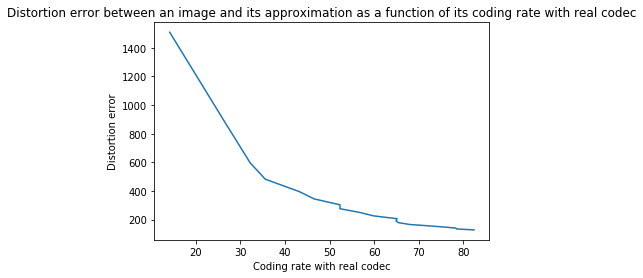

In [44]:
X, Y = [], []
for k in range(2, 21) :
    X.append(R_real_codec(A, k))
    Y.append(D(A, k))
plt.title("Distortion error between an image and its approximation as a function of its coding rate with real codec")
plt.plot(X, Y)
plt.xlabel("Coding rate with real codec")
plt.ylabel("Distortion error")
plt.show()

De manière logique, la courbe décroît à nouveau.

On peut également remarquer que pour une erreur quadratique moyenne donnée, la longueur d'encodage est deux fois plus importante : en effet, un caractère est codé sur deux fois plus de bits qu'un entier.

Une amélioration à faire pour cet encodage est donc, à partir d'un tableau issu d'un codage RLE, de coder nos données (c'est-à-dire les quatre entiers de chaque ligne du tableau) sur un type de données qui ne soit encodé que sur 8 bits. En effet, 8 bits suffisent pour coder des entiers compris entre 0 et 255 : c'est le cas des trois entiers représentant un pixel ; en revanche, il ne faudra pas qu'un même pixel apparaissent plus de 256 fois d'affilée, de manière à ce que l'entier représentant le nombre de fois d'affilée où un pixel apparaît puisse lui aussi être codé sur 8 bits.